In [1]:
# Cell 1: environment, reproducibility, and imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Reproducibility (best-effort)
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# TensorFlow/Keras imports
import tensorflow as tf
tf.random.set_seed(SEED)

from tensorflow.keras import layers, models, callbacks, optimizers, regularizers

# sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

print("TensorFlow version:", tf.__version__)


2025-11-22 11:23:53.398923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763810633.834083      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763810633.953065      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow version: 2.18.0


In [2]:
# Cell 2: load processed CSVs
TRAIN_PATH = "/kaggle/input/processed-financial-risk/train_processed.csv"
TEST_PATH  = "/kaggle/input/processed-financial-risk/test_processed.csv"
SAMPLE_SUB_PATH = "/kaggle/input/financial-risk-profiling/sample_submission_updated.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)

print("train:", train.shape)
print("test :", test.shape)
print("sample_submission:", sample_sub.shape)
display(train.head())


train: (204277, 27)
test : (51070, 26)
sample_submission: (51070, 2)


,ProfileID,orig_index,ApplicantYears,AnnualEarnings,RequestedSum,TrustMetric,WorkDuration,ActiveAccounts,OfferRate,RepayPeriod,...,RelationshipStatus_Married,RelationshipStatus_Single,OwnsProperty_Yes,FamilyObligation_Yes,FundUseCase_Business,FundUseCase_Education,FundUseCase_Home,FundUseCase_Other,JointApplicant_Yes,RiskFlag
0,DRIRC89L0T,0,-1.699838,1.413785,1.151487,1.711544,-0.967182,-0.449530,-0.454811,1.415720,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,TS0FIUNHNU,1,0.234120,-0.649831,-1.715866,1.094714,-0.851727,-0.449530,0.939092,-0.000645,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
2,I0YR284A1V,2,-1.166333,0.046770,-0.458437,-0.762072,-1.515594,-0.449530,1.621727,-1.417010,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
3,WB1T7NQV8A,3,0.634249,-0.839783,1.440049,-0.258537,1.370784,0.445809,0.143437,1.415720,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,J6GU9M4G1Z,4,0.367496,0.845753,-1.488613,1.673779,-1.717640,1.341148,1.656386,-1.417010,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0


In [3]:
# Cell 3: prepare X, y, drop ProfileID
TARGET = "RiskFlag"
IDCOL = "ProfileID"

# Confirm target present
if TARGET not in train.columns:
    raise ValueError(f"Target column '{TARGET}' not found in train file.")

# Keep profile IDs for submission mapping
test_profile_ids = test[IDCOL].copy()
train_profile_ids = train[IDCOL].copy()

# Build feature matrices (drop ProfileID and RiskFlag from train; drop ProfileID from test)
X = train.drop(columns=[IDCOL, TARGET])
y = train[TARGET].astype(int)

X_test = test.drop(columns=[IDCOL])  # features for final inference
X = train.drop(columns=[IDCOL, TARGET, "orig_index"])
y = train[TARGET].astype(int)
X_test = test.drop(columns=[IDCOL, "orig_index"])


print("Feature columns count:", X.shape[1])


Feature columns count: 24


In [4]:
def add_features(df):
    df["LoanToIncome"] = df["RequestedSum"] / (df["AnnualEarnings"] + 1)
    df["DebtToTrust"] = df["DebtFactor"] / (df["TrustMetric"] + 1)
    df["IncomePerAccount"] = df["AnnualEarnings"] / (df["ActiveAccounts"] + 1)
    df["TenureYears"] = df["WorkDuration"] / 12
    df["Age*Trust"] = df["ApplicantYears"] * df["TrustMetric"]
    df["Loan*Rate"] = df["RequestedSum"] * df["OfferRate"]
    df["DTI*Rate"] = df["DebtFactor"] * df["OfferRate"]
    return df

X = add_features(X)
X_test = add_features(X_test)

print("New feature count:", X.shape[1])


New feature count: 31


In [5]:
# Cell 4: stratified train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=SEED
)

print("X_train:", X_train.shape, "X_val:", X_val.shape)
# Class weights to handle imbalance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weights)


X_train: (173635, 31) X_val: (30642, 31)
Class weights: {0: 0.5657890449346672, 1: 4.300024764735017}


In [6]:
def build_model(input_dim, lr=3e-4, l2=1e-6, dropout_rate=0.2):

    inputs = layers.Input(shape=(input_dim,), name="features")
    x = layers.BatchNormalization()(inputs)

    # BLOCK 1
    x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # BLOCK 2
    x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    # BLOCK 3
    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate*0.6)(x)

    # BLOCK 4
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate*0.5)(x)

    # BLOCK 5 (SMALL COMPRESSION)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate*0.4)(x)

    out = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, out)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(name="auc")]
    )

    return model


In [7]:
MODEL_SAVE_PATH = "best_nn_model.keras"   # new format

EPOCHS = 60
BATCH_SIZE = 2048

lr_sched = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=3e-4,
    first_decay_steps=10,
    t_mul=2.0,
    m_mul=0.8,
    alpha=1e-6
)

early = callbacks.EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=12,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    MODEL_SAVE_PATH,
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)

model = build_model(X_train.shape[1], lr=lr_sched)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[early, checkpoint],
    verbose=2
)


2025-11-22 11:24:21.952729: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/60

Epoch 1: val_auc improved from -inf to 0.70161, saving model to best_nn_model.keras
85/85 - 14s - 164ms/step - auc: 0.6543 - loss: 0.7104 - val_auc: 0.7016 - val_loss: 0.6115
Epoch 2/60

Epoch 2: val_auc improved from 0.70161 to 0.71199, saving model to best_nn_model.keras
85/85 - 9s - 105ms/step - auc: 0.6864 - loss: 0.6661 - val_auc: 0.7120 - val_loss: 0.5735
Epoch 3/60

Epoch 3: val_auc improved from 0.71199 to 0.72582, saving model to best_nn_model.keras
85/85 - 9s - 105ms/step - auc: 0.6986 - loss: 0.6496 - val_auc: 0.7258 - val_loss: 0.5477
Epoch 4/60

Epoch 4: val_auc improved from 0.72582 to 0.73284, saving model to best_nn_model.keras
85/85 - 9s - 105ms/step - auc: 0.7071 - loss: 0.6399 - val_auc: 0.7328 - val_loss: 0.5556
Epoch 5/60

Epoch 5: val_auc improved from 0.73284 to 0.73841, saving model to best_nn_model.keras
85/85 - 9s - 109ms/step - auc: 0.7112 - loss: 0.6345 - val_auc: 0.7384 - val_loss: 0.5711
Epoch 6/60

Epoch 6: val_auc improved from 0.73841 to 0.7

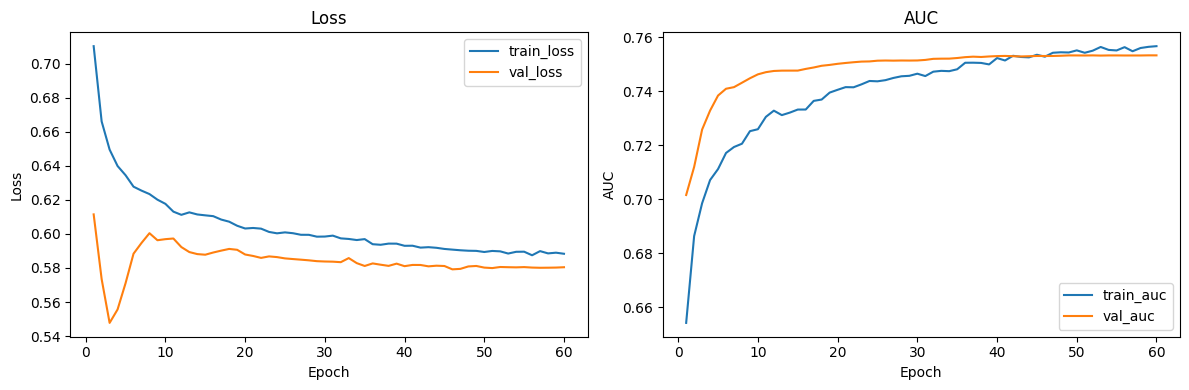

In [8]:
# Cell 7: plot training curves
hist = history.history
epochs_range = range(1, len(hist['loss']) + 1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, hist['loss'], label='train_loss')
plt.plot(epochs_range, hist['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(epochs_range, hist['auc'], label='train_auc')
plt.plot(epochs_range, hist['val_auc'], label='val_auc')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.legend(); plt.title('AUC')

plt.tight_layout()
plt.show()


In [9]:
# Cell 8: evaluate on validation set
best_model = models.load_model(MODEL_SAVE_PATH, compile=True)

val_preds_prob = best_model.predict(X_val, batch_size=2048).ravel()
val_preds = (val_preds_prob >= 0.5).astype(int)

auc = roc_auc_score(y_val, val_preds_prob)
acc = accuracy_score(y_val, val_preds)
f1 = f1_score(y_val, val_preds)
prec = precision_score(y_val, val_preds)
rec = recall_score(y_val, val_preds)
cm = confusion_matrix(y_val, val_preds)

print(f"Validation AUC: {auc:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1: {f1:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}")
print("Confusion matrix:\n", cm)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Validation AUC: 0.7533
Validation Accuracy: 0.6881
Validation F1: 0.3390  Precision: 0.2249  Recall: 0.6876
Confusion matrix:
 [[18636  8443]
 [ 1113  2450]]


In [10]:
# Cell 9: find threshold that maximizes F1 on validation
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_val, val_preds_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
best_idx = np.nanargmax(f1_scores)
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
best_f1 = f1_scores[best_idx]

print("Best threshold (val) by F1:", best_threshold)
print("Best F1 (val):", best_f1)

# show metrics at that threshold
val_preds_thr = (val_preds_prob >= best_threshold).astype(int)
print("Metrics at best threshold:")
print("Accuracy:", accuracy_score(y_val, val_preds_thr))
print("F1:", f1_score(y_val, val_preds_thr))
print("Precision:", precision_score(y_val, val_preds_thr))
print("Recall:", recall_score(y_val, val_preds_thr))


Best threshold (val) by F1: 0.6189664
Best F1 (val): 0.3715890850717718
Metrics at best threshold:
Accuracy: 0.7955747013902487
F1: 0.3715890850722311
Precision: 0.2891491022638564
Recall: 0.5197866966039854


In [11]:
# Cell 10: predict on test and create submission file
# Use best model and best_threshold found above
test_probs = best_model.predict(X_test, batch_size=2048).ravel()

# Create submission DF matching sample submission format.
# If sample_sub contains columns like ProfileID and RiskFlag, we follow that.
sub = sample_sub.copy()

# If sample_sub has ProfileID column - replace RiskFlag column with our predictions
if "ProfileID" in sub.columns and "RiskFlag" in sub.columns:
    # ensure ordering: sample_sub's ProfileIDs should match test_profile_ids ideally
    # We'll map by ProfileID to be safe
    preds_df = pd.DataFrame({IDCOL: test_profile_ids, "RiskFlag": test_probs})
    # Merge onto sample submission (left join on ProfileID)
    sub = sub.drop(columns=["RiskFlag"], errors='ignore').merge(preds_df, on=IDCOL, how="left")
else:
    # fallback: create new
    sub = pd.DataFrame({IDCOL: test_profile_ids, "RiskFlag": test_probs})

# Optionally create binary label column using best_threshold
sub["RiskFlag_bin"] = (sub["RiskFlag"] >= best_threshold).astype(int)

# Save probability submission (and binary column for reference)
OUT_PATH = "nn_submission_prob.csv"
OUT_PATH_BIN = "nn_submission_binary.csv"
sub.to_csv(OUT_PATH, index=False)
# If you want binary-only submission (if competition expects 0/1), save that too:
sub[[IDCOL, "RiskFlag_bin"]].rename(columns={"RiskFlag_bin":"RiskFlag"}).to_csv(OUT_PATH_BIN, index=False)

print("Saved probability submission to:", OUT_PATH)
print("Saved binary submission to:", OUT_PATH_BIN)
display(sub.head())


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Saved probability submission to: nn_submission_prob.csv
Saved binary submission to: nn_submission_binary.csv


,ProfileID,RiskFlag,RiskFlag_bin
0,CKV34LU7V7,0.184478,0
1,62KTYNH93J,0.262510,0
2,JGFUSOIUH7,0.280668,0
3,4538THBHOX,0.543706,0
4,DXLNA06JHR,0.528383,0


In [12]:
# Cell 11: (Optional, compute simple permutation importance on validation subset)
# This is expensive; run on a small subset if you want quick signal
try:
    from copy import deepcopy
    Xv_small = X_val.sample(n=min(2000, len(X_val)), random_state=SEED)
    yv_small = y_val.loc[Xv_small.index]
    base_auc = roc_auc_score(yv_small, best_model.predict(Xv_small).ravel())
    importances = {}
    for col in Xv_small.columns:
        X_perm = Xv_small.copy()
        X_perm[col] = np.random.permutation(X_perm[col].values)
        perm_auc = roc_auc_score(yv_small, best_model.predict(X_perm).ravel())
        importances[col] = base_auc - perm_auc
    imp_series = pd.Series(importances).sort_values(ascending=False).head(20)
    print("Top permutation importances (delta AUC):")
    display(imp_series)
except Exception as e:
    print("Permutation importance skipped or failed:", str(e))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━

ApplicantYears                 0.087130
AnnualEarnings                 0.044021
OfferRate                      0.039236
RequestedSum                   0.039074
WorkCategory_Unemployed        0.006678
WorkCategory_Part-time         0.006659
QualificationLevel_Master's    0.005420
ActiveAccounts                 0.005368
TenureYears                    0.004208
JointApplicant_Yes             0.004087
RelationshipStatus_Married     0.003936
IncomePerAccount               0.002708
FundUseCase_Business           0.002583
Loan*Rate                      0.002373
FundUseCase_Home               0.001411
Age*Trust                      0.001174
WorkCategory_Self-employed     0.001068
RelationshipStatus_Single      0.000612
TrustMetric                    0.000605
DTI*Rate                       0.000264
dtype: float64